# Module 01: Attention Mechanism - Interactive Exploration

Welcome to the interactive attention notebook! Here you'll:

1. **Visualize** attention patterns in action
2. **Experiment** with different inputs and see how attention responds
3. **Understand** each component through hands-on exploration
4. **Debug** common issues interactively
5. **Build intuition** through experimentation

**Prerequisites:**
- Read `theory.md` for conceptual understanding
- Try `exercises.py` to practice implementation
- Have PyTorch installed

**Time:** 60-90 minutes

Let's dive in!

In [1]:
# Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

# Import our attention implementation
import sys
sys.path.append('../../../')
from tiny_transformer.attention import scaled_dot_product_attention, create_causal_mask
from tiny_transformer.utils import plot_attention_pattern, check_shape

print("✓ All imports successful!")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

✓ All imports successful!


## Part 1: Understanding the Components

### 1.1 Query, Key, Value - What Are They?

In [2]:
# Create simple example with small dimensions for clarity
batch_size = 1
seq_len = 4  # Short sequence to visualize
d_k = 8      # Small dimension

# Create Q, K, V
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

print(f"Query shape: {Q.shape}  (batch, positions, d_k)")
print(f"Key shape:   {K.shape}  (batch, positions, d_k)")
print(f"Value shape: {V.shape}  (batch, positions, d_k)")

print("\nThink of it like a database:")
print("  Query  = what you're searching for")
print("  Key    = index/metadata of each item")
print("  Value  = actual content of each item")
print("\nAttention finds which Keys match your Queries,")
print("then returns a weighted combination of the corresponding Values.")

Query shape: torch.Size([1, 4, 8])  (batch, positions, d_k)
Key shape:   torch.Size([1, 4, 8])  (batch, positions, d_k)
Value shape: torch.Size([1, 4, 8])  (batch, positions, d_k)

Think of it like a database:
  Query  = what you're searching for
  Key    = index/metadata of each item
  Value  = actual content of each item

Attention finds which Keys match your Queries,
then returns a weighted combination of the corresponding Values.


### 1.2 Step 1: Computing Attention Scores (Q @ K^T)

Scores shape: torch.Size([1, 4, 4])  (batch, queries, keys)

Each position (query) has a score for every other position (key)

Raw scores for first batch:
tensor([[-5.8108, -3.6962, -4.3623, -8.6428],
        [-3.5380,  4.3192, -1.4130,  1.1963],
        [-3.0255, -1.0973, -1.4376,  1.4581],
        [-1.5793, -1.7662, -1.5380,  0.7021]])


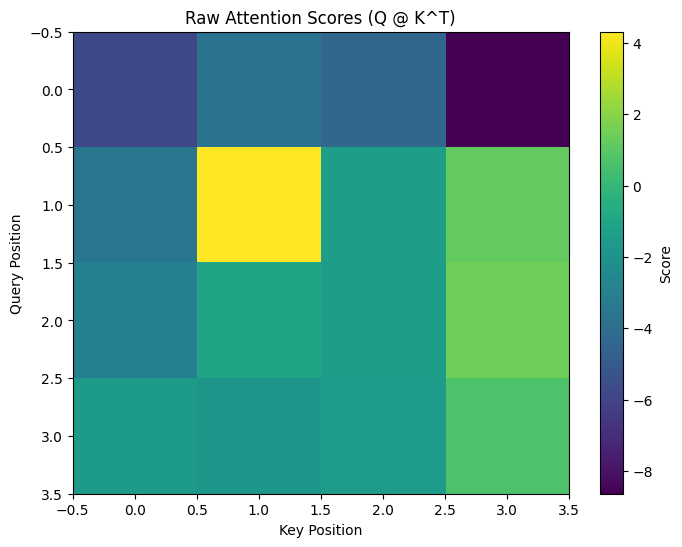


Interpretation:
  Brighter = higher similarity
  Each row shows how query i relates to all keys


In [3]:
# Step 1: Compute similarity scores
scores = Q @ K.transpose(-2, -1)  # (batch, seq_len, d_k) @ (batch, d_k, seq_len)

print(f"Scores shape: {scores.shape}  (batch, queries, keys)")
print("\nEach position (query) has a score for every other position (key)")
print(f"\nRaw scores for first batch:\n{scores[0]}")

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(scores[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Score')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Raw Attention Scores (Q @ K^T)')
plt.show()

print("\nInterpretation:")
print("  Brighter = higher similarity")
print("  Each row shows how query i relates to all keys")

### 1.3 Step 2: Scaling (Divide by √d_k)

Before scaling - Mean: -1.8895, Std: 3.0731
After scaling  - Mean: -0.6680, Std: 1.0865


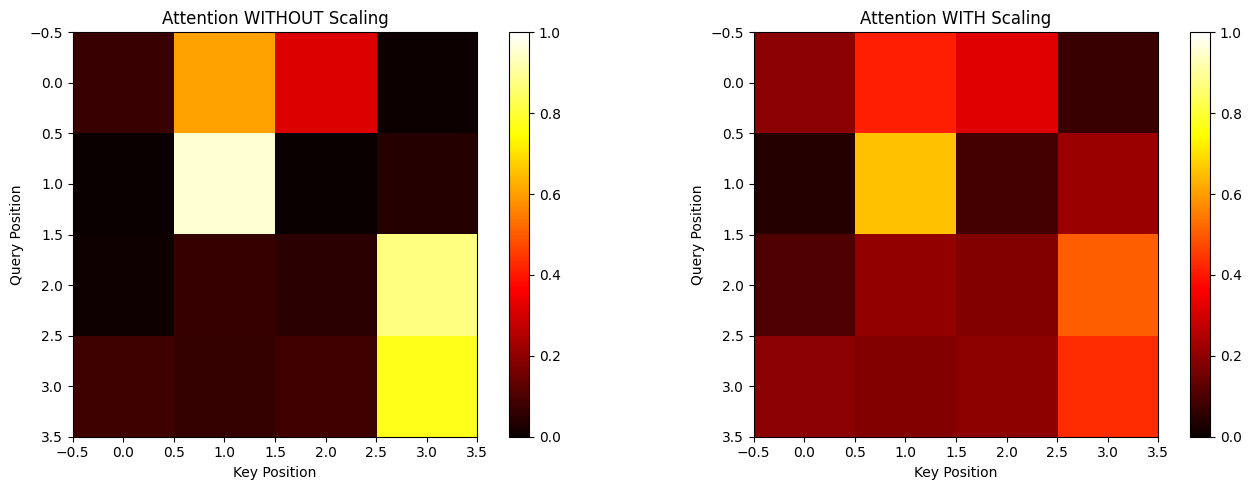


Why scaling matters:
  Unscaled: Softmax becomes too 'peaky' (one-hot like)
  Scaled: More balanced attention distribution
  This is crucial for gradient flow during training!


In [4]:
# Compare scaled vs unscaled
scores_unscaled = Q @ K.transpose(-2, -1)
scores_scaled = scores_unscaled / math.sqrt(d_k)

print(f"Before scaling - Mean: {scores_unscaled.mean():.4f}, Std: {scores_unscaled.std():.4f}")
print(f"After scaling  - Mean: {scores_scaled.mean():.4f}, Std: {scores_scaled.std():.4f}")

# Effect on softmax
attn_unscaled = F.softmax(scores_unscaled[0], dim=-1)
attn_scaled = F.softmax(scores_scaled[0], dim=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

im1 = ax1.imshow(attn_unscaled.detach().numpy(), cmap='hot', vmin=0, vmax=1)
ax1.set_title('Attention WITHOUT Scaling')
ax1.set_xlabel('Key Position')
ax1.set_ylabel('Query Position')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(attn_scaled.detach().numpy(), cmap='hot', vmin=0, vmax=1)
ax2.set_title('Attention WITH Scaling')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("\nWhy scaling matters:")
print("  Unscaled: Softmax becomes too 'peaky' (one-hot like)")
print("  Scaled: More balanced attention distribution")
print("  This is crucial for gradient flow during training!")

### 1.4 Step 3: Softmax (Convert to Probabilities)

Attention weights shape: torch.Size([1, 4, 4])

First query's attention distribution:
tensor([0.1942, 0.4102, 0.3242, 0.0714])

Sum: 1.000000 (should be 1.0)


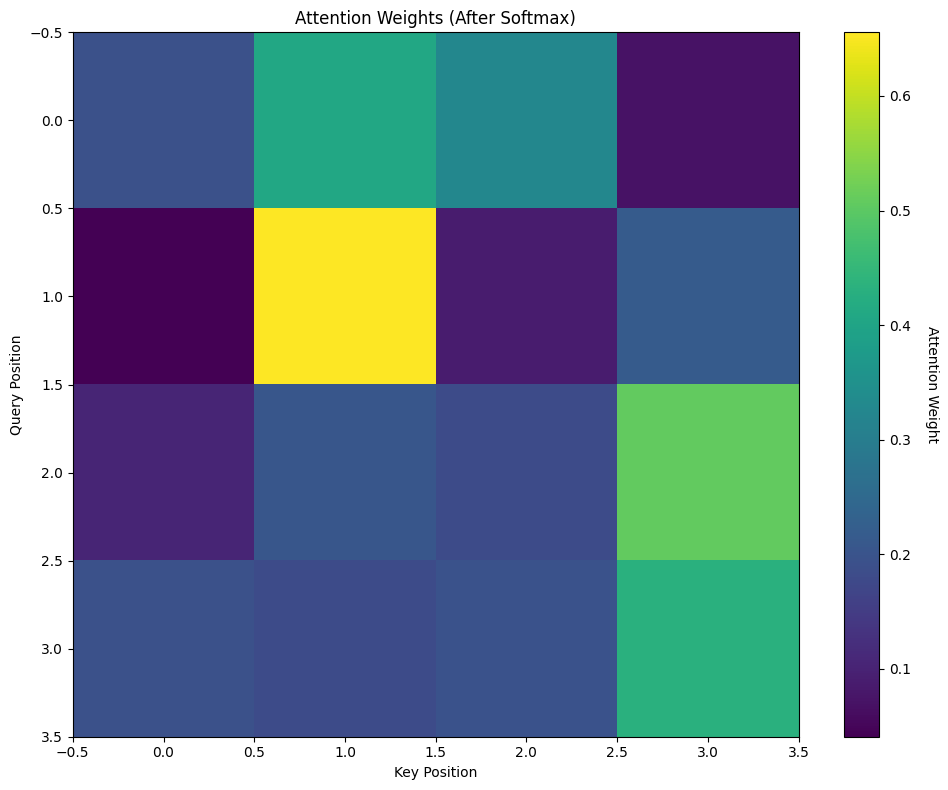


Key properties:
  ✓ All values between 0 and 1
  ✓ Each row sums to 1 (probability distribution)
  ✓ Shows 'how much' each query attends to each key


In [5]:
# Apply softmax
attention_weights = F.softmax(scores_scaled, dim=-1)

print(f"Attention weights shape: {attention_weights.shape}")
print(f"\nFirst query's attention distribution:")
print(attention_weights[0, 0])
print(f"\nSum: {attention_weights[0, 0].sum():.6f} (should be 1.0)")

# Visualize all attention patterns
plot_attention_pattern(
    attention_weights[0],
    title="Attention Weights (After Softmax)"
)
plt.show()

print("\nKey properties:")
print("  ✓ All values between 0 and 1")
print("  ✓ Each row sums to 1 (probability distribution)")
print("  ✓ Shows 'how much' each query attends to each key")

### 1.5 Step 4: Apply Attention to Values

In [6]:
# Weighted sum of values
output = attention_weights @ V

print(f"Output shape: {output.shape}  (same as Q, K, V)")
print("\nWhat happened:")
print("  For each query position, we computed a weighted average of ALL values")
print("  Weights determined by attention (how much each key matches the query)")

# Demonstrate for first position
pos = 0
print(f"\nPosition {pos}:")
print(f"  Attention weights: {attention_weights[0, pos]}")
print(f"  Output: weighted combo of all 4 value vectors")

# Verify manually
manual_output = torch.zeros(d_k)
for i in range(seq_len):
    manual_output += attention_weights[0, pos, i] * V[0, i]

print(f"\nManual calculation matches: {torch.allclose(manual_output, output[0, pos])}")

Output shape: torch.Size([1, 4, 8])  (same as Q, K, V)

What happened:
  For each query position, we computed a weighted average of ALL values
  Weights determined by attention (how much each key matches the query)

Position 0:
  Attention weights: tensor([0.1942, 0.4102, 0.3242, 0.0714])
  Output: weighted combo of all 4 value vectors

Manual calculation matches: True


## Part 2: Complete Attention Mechanism

Input shapes:  Q=torch.Size([1, 4, 8]), K=torch.Size([1, 4, 8]), V=torch.Size([1, 4, 8])
Output shapes: output=torch.Size([1, 4, 8]), attention=torch.Size([1, 4, 4])


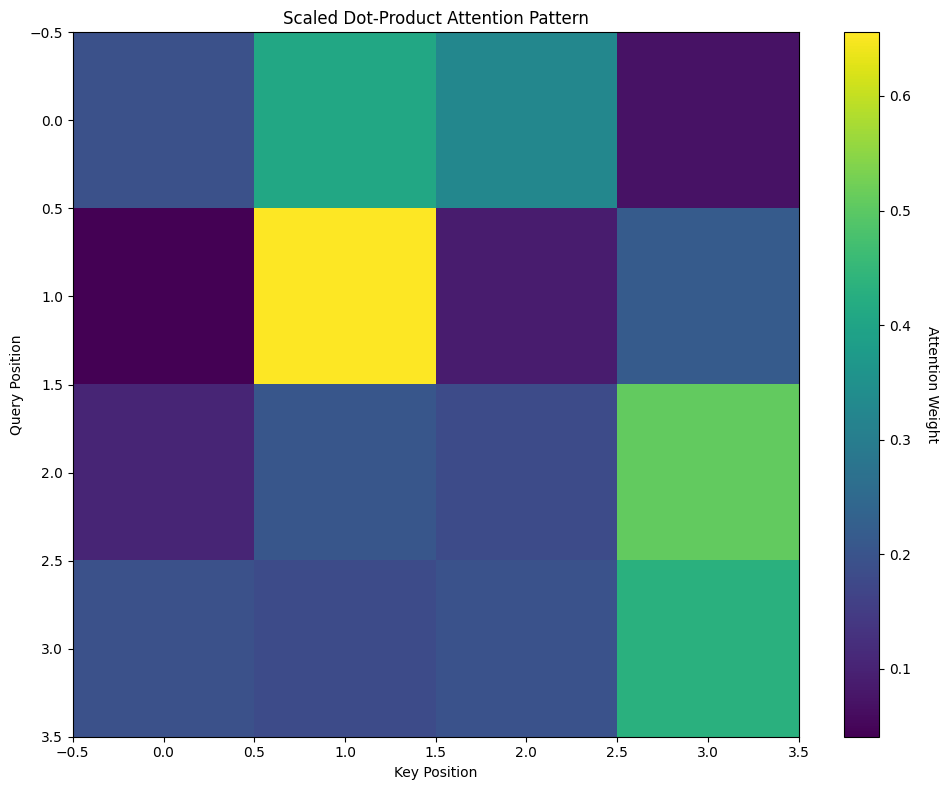


✓ Complete attention mechanism in one function call!


In [7]:
# Use our implementation
output, attention = scaled_dot_product_attention(Q, K, V)

print(f"Input shapes:  Q={Q.shape}, K={K.shape}, V={V.shape}")
print(f"Output shapes: output={output.shape}, attention={attention.shape}")

# Visualize the attention pattern
plot_attention_pattern(
    attention[0],
    title="Scaled Dot-Product Attention Pattern"
)
plt.show()

print("\n✓ Complete attention mechanism in one function call!")

## Part 3: Causal Masking for Autoregressive Models

In language models, we need to prevent attending to future tokens.

Causal mask (1=allowed, 0=blocked):
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])


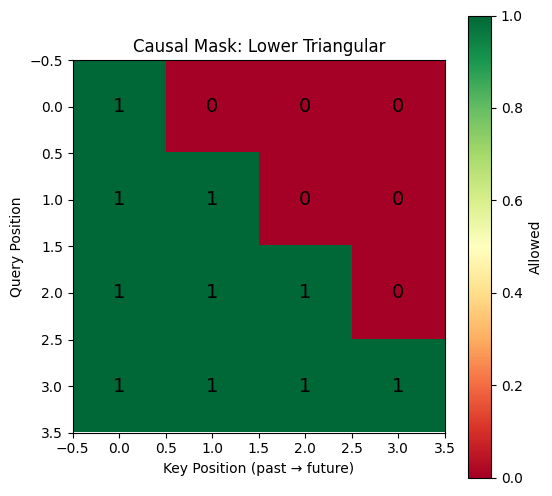


Interpretation:
  Position 0 can only attend to itself (first token)
  Position 1 can attend to positions 0, 1 (past and present)
  Position 2 can attend to positions 0, 1, 2
  etc.

  → Prevents 'cheating' by looking at future tokens!


In [8]:
# Create causal mask
mask = create_causal_mask(seq_len)

print("Causal mask (1=allowed, 0=blocked):")
print(mask)

# Visualize
plt.figure(figsize=(6, 6))
# Convert mask for visualization: 0 -> 1 (allowed), -inf -> 0 (blocked)
mask_display = (mask != float('-inf')).float()
plt.imshow(mask_display.numpy(), cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(label='Allowed')
plt.xlabel('Key Position (past → future)')
plt.ylabel('Query Position')
plt.title('Causal Mask: Lower Triangular')
for i in range(seq_len):
    for j in range(seq_len):
        # Display 1 for allowed (0.0 in mask), 0 for blocked (-inf in mask)
        display_val = 1 if mask[i, j] != float('-inf') else 0
        plt.text(j, i, display_val, 
                ha='center', va='center', color='black', fontsize=14)
plt.show()

print("\nInterpretation:")
print("  Position 0 can only attend to itself (first token)")
print("  Position 1 can attend to positions 0, 1 (past and present)")
print("  Position 2 can attend to positions 0, 1, 2")
print("  etc.")
print("\n  → Prevents 'cheating' by looking at future tokens!")

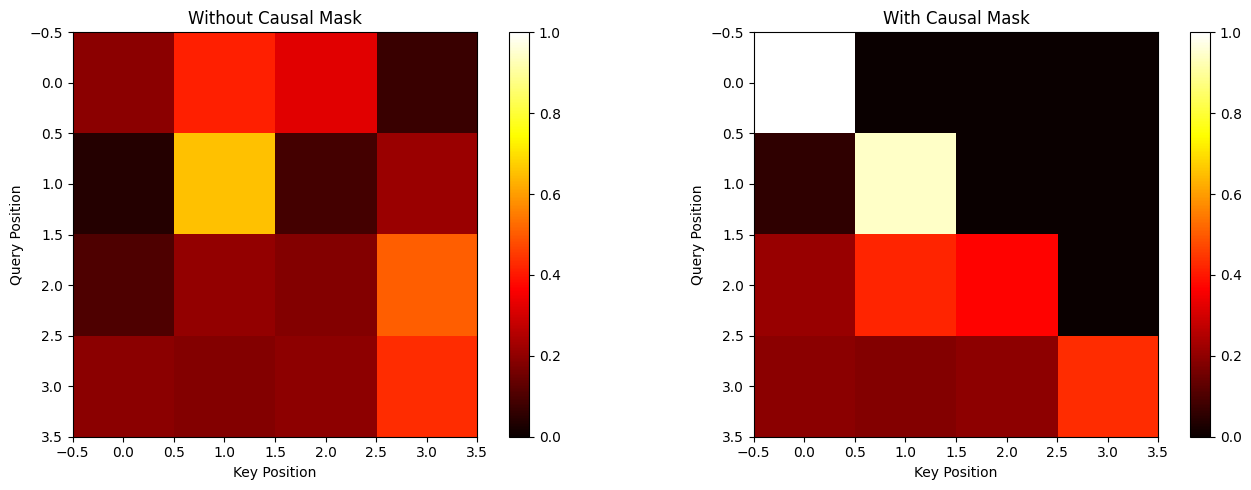

Notice:
  Right plot has upper triangle = 0 (blocked)
  Attention only flows backwards and to current position
  This is essential for autoregressive generation!


In [9]:
# Apply causal masking to attention
output_masked, attention_masked = scaled_dot_product_attention(Q, K, V, mask=mask.unsqueeze(0))

# Compare masked vs unmasked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

im1 = ax1.imshow(attention[0].detach().numpy(), cmap='hot', vmin=0, vmax=1)
ax1.set_title('Without Causal Mask')
ax1.set_xlabel('Key Position')
ax1.set_ylabel('Query Position')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(attention_masked[0].detach().numpy(), cmap='hot', vmin=0, vmax=1)
ax2.set_title('With Causal Mask')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("Notice:")
print("  Right plot has upper triangle = 0 (blocked)")
print("  Attention only flows backwards and to current position")
print("  This is essential for autoregressive generation!")

## Part 4: Experimenting with Different Inputs

### 4.1 What Happens with Identical Keys?

Attention with identical keys:
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])


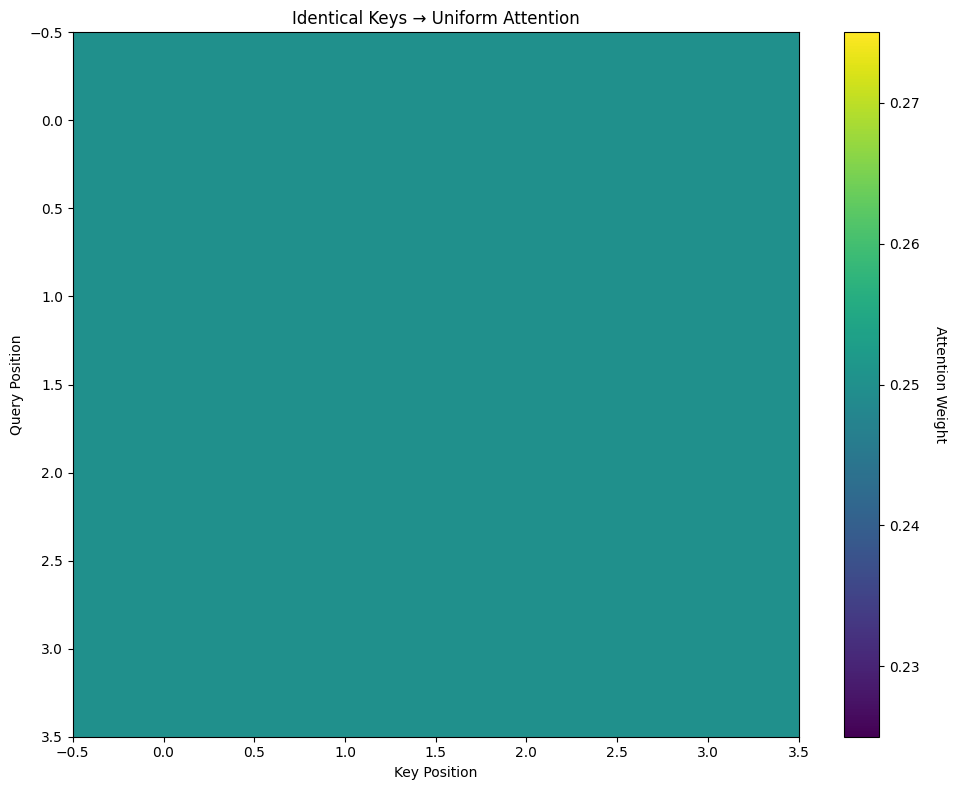


Observation:
  When all keys are the same, attention is uniform (equal weights)
  Makes sense: nothing distinguishes one position from another!


In [10]:
# Create Q with one query different from others
Q_exp = torch.randn(1, 4, 8)

# Make all keys identical
K_identical = torch.ones(1, 4, 8)  # All the same!
V_exp = torch.randn(1, 4, 8)

output_exp, attention_exp = scaled_dot_product_attention(Q_exp, K_identical, V_exp)

print("Attention with identical keys:")
print(attention_exp[0])

plot_attention_pattern(attention_exp[0], title="Identical Keys → Uniform Attention")
plt.show()

print("\nObservation:")
print("  When all keys are the same, attention is uniform (equal weights)")
print("  Makes sense: nothing distinguishes one position from another!")

### 4.2 What About One Very Similar Query-Key Pair?

Attention when Q[0] ≈ K[2]:
tensor([[0.0166, 0.0738, 0.8235, 0.0861],
        [0.2213, 0.3662, 0.1066, 0.3059],
        [0.1775, 0.1149, 0.4395, 0.2681],
        [0.0753, 0.0707, 0.1627, 0.6912]])

Query 0 attention to Key 2: 0.8235


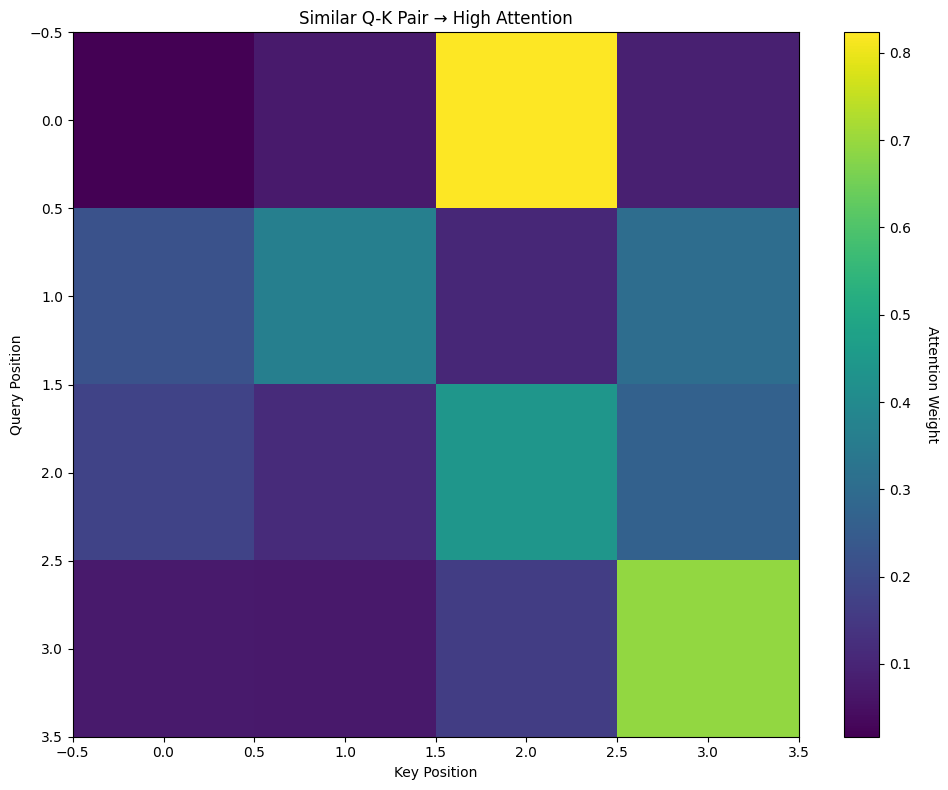


Observation:
  Query 0 attends strongly to Key 2 (high similarity)
  This is the core mechanism: similar vectors attract attention!


In [11]:
# Create scenario where Q[0] and K[2] are very similar
Q_similar = torch.randn(1, 4, 8)
K_similar = torch.randn(1, 4, 8)

# Make Q[0] ≈ K[2]
K_similar[0, 2] = Q_similar[0, 0] + 0.1 * torch.randn(8)  # Almost identical

V_similar = torch.randn(1, 4, 8)

output_similar, attention_similar = scaled_dot_product_attention(Q_similar, K_similar, V_similar)

print("Attention when Q[0] ≈ K[2]:")
print(attention_similar[0])
print(f"\nQuery 0 attention to Key 2: {attention_similar[0, 0, 2].item():.4f}")

plot_attention_pattern(attention_similar[0], title="Similar Q-K Pair → High Attention")
plt.show()

print("\nObservation:")
print("  Query 0 attends strongly to Key 2 (high similarity)")
print("  This is the core mechanism: similar vectors attract attention!")

## Part 5: Scaling Effects

Let's visualize why scaling by √d_k matters.

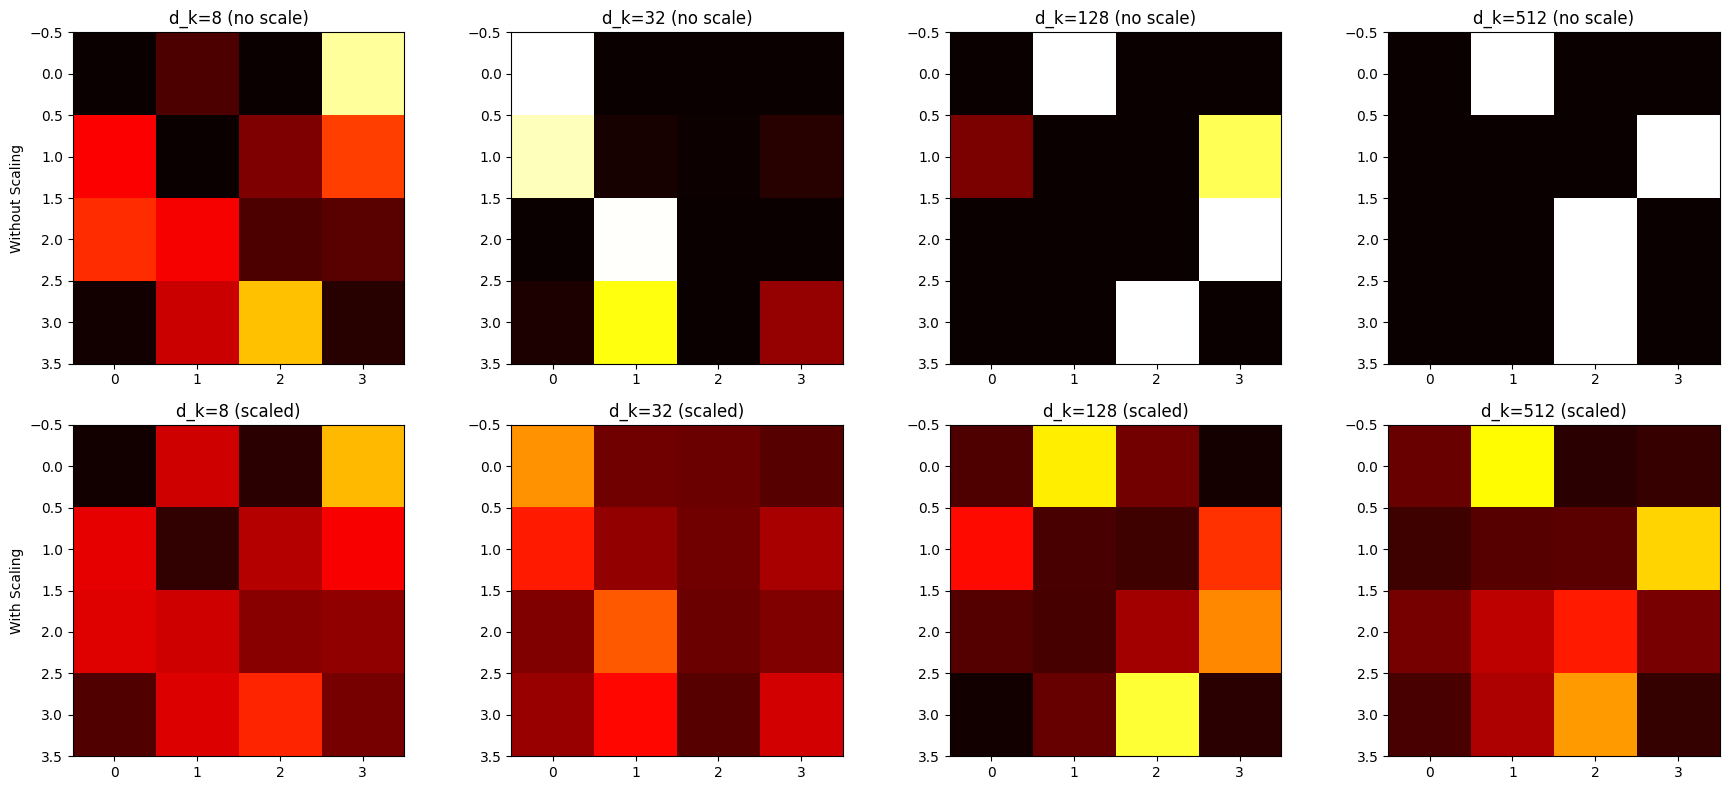

Key observation:
  Top row (no scaling): As d_k increases, attention becomes MORE peaked
  Bottom row (scaled): Attention remains balanced regardless of d_k

  → Scaling makes training stable across different model sizes!


In [12]:
# Test with different d_k values
d_k_values = [8, 32, 128, 512]
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for idx, d_k_test in enumerate(d_k_values):
    Q_test = torch.randn(1, 4, d_k_test)
    K_test = torch.randn(1, 4, d_k_test)
    V_test = torch.randn(1, 4, d_k_test)
    
    # Without scaling
    scores_no_scale = Q_test @ K_test.transpose(-2, -1)
    attn_no_scale = F.softmax(scores_no_scale, dim=-1)
    
    # With scaling
    scores_with_scale = scores_no_scale / math.sqrt(d_k_test)
    attn_with_scale = F.softmax(scores_with_scale, dim=-1)
    
    # Plot without scaling
    im1 = axes[0, idx].imshow(attn_no_scale[0].detach().numpy(), cmap='hot', vmin=0, vmax=1)
    axes[0, idx].set_title(f'd_k={d_k_test} (no scale)')
    if idx == 0:
        axes[0, idx].set_ylabel('Without Scaling')
    
    # Plot with scaling
    im2 = axes[1, idx].imshow(attn_with_scale[0].detach().numpy(), cmap='hot', vmin=0, vmax=1)
    axes[1, idx].set_title(f'd_k={d_k_test} (scaled)')
    if idx == 0:
        axes[1, idx].set_ylabel('With Scaling')

plt.tight_layout()
plt.show()

print("Key observation:")
print("  Top row (no scaling): As d_k increases, attention becomes MORE peaked")
print("  Bottom row (scaled): Attention remains balanced regardless of d_k")
print("\n  → Scaling makes training stable across different model sizes!")

## Part 6: Real-World Example - Text Attention

Let's simulate attention on actual text!

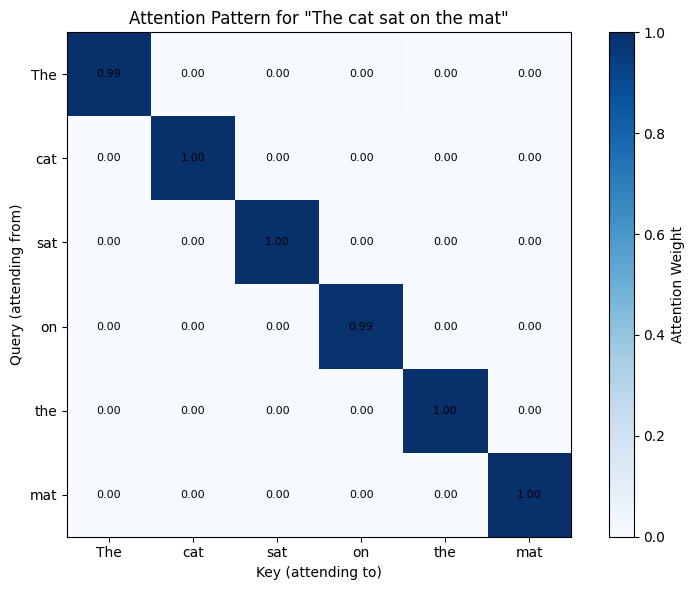


Interpretation:
  Each word (row) shows how much it attends to every other word (columns)
  In real models, semantically related words attend more to each other
  (Our random embeddings don't have semantic meaning, so patterns are random)


In [13]:
# Simulate a simple sentence
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len_text = len(sentence)
d_model = 64

# Create random embeddings (in reality, these come from an embedding layer)
embeddings = torch.randn(1, seq_len_text, d_model)

# For simplicity, use embeddings as Q, K, V
Q_text = embeddings
K_text = embeddings
V_text = embeddings

# Compute attention
output_text, attention_text = scaled_dot_product_attention(Q_text, K_text, V_text)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(attention_text[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
plt.colorbar(label='Attention Weight')
plt.xticks(range(seq_len_text), sentence)
plt.yticks(range(seq_len_text), sentence)
plt.xlabel('Key (attending to)')
plt.ylabel('Query (attending from)')
plt.title('Attention Pattern for "The cat sat on the mat"')

# Add values
for i in range(seq_len_text):
    for j in range(seq_len_text):
        text = plt.text(j, i, f"{attention_text[0, i, j].item():.2f}",
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Each word (row) shows how much it attends to every other word (columns)")
print("  In real models, semantically related words attend more to each other")
print("  (Our random embeddings don't have semantic meaning, so patterns are random)")

### With Causal Mask (Autoregressive)

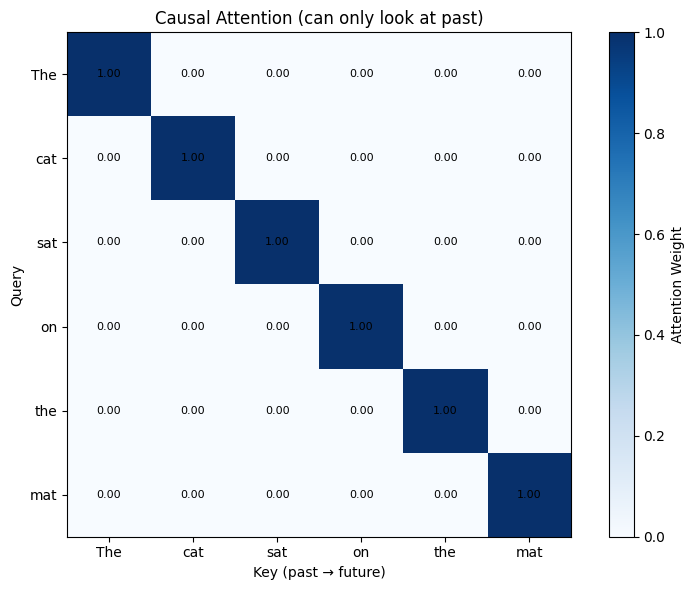


Notice:
  'cat' can only attend to 'The' and 'cat' (past and present)
  'mat' can attend to all previous words
  Upper triangle is all zeros (future is blocked)


In [14]:
# Apply causal mask
mask_text = create_causal_mask(seq_len_text)
output_causal, attention_causal = scaled_dot_product_attention(
    Q_text, K_text, V_text, mask=mask_text.unsqueeze(0)
)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(attention_causal[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
plt.colorbar(label='Attention Weight')
plt.xticks(range(seq_len_text), sentence)
plt.yticks(range(seq_len_text), sentence)
plt.xlabel('Key (past → future)')
plt.ylabel('Query')
plt.title('Causal Attention (can only look at past)')

for i in range(seq_len_text):
    for j in range(seq_len_text):
        text = plt.text(j, i, f"{attention_causal[0, i, j].item():.2f}",
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

print("\nNotice:")
print("  'cat' can only attend to 'The' and 'cat' (past and present)")
print("  'mat' can attend to all previous words")
print("  Upper triangle is all zeros (future is blocked)")

## Part 7: Performance and Complexity

Let's measure attention's time and memory complexity.

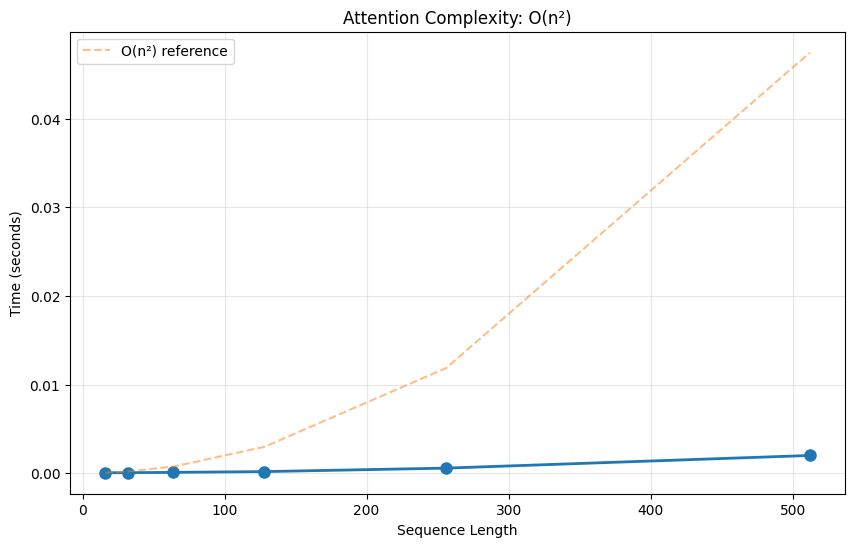


Observations:
  Time grows quadratically with sequence length
  Doubling seq_len → 4x the time
  This is why transformers struggle with very long sequences!

  Solutions: sparse attention, linear attention, etc. (advanced topics)


In [15]:
import time

seq_lengths = [16, 32, 64, 128, 256, 512]
d_k = 64
batch_size = 8

times = []

for seq_len in seq_lengths:
    Q = torch.randn(batch_size, seq_len, d_k)
    K = torch.randn(batch_size, seq_len, d_k)
    V = torch.randn(batch_size, seq_len, d_k)
    
    # Warmup
    _ = scaled_dot_product_attention(Q, K, V)
    
    # Measure
    start = time.time()
    for _ in range(100):
        _ = scaled_dot_product_attention(Q, K, V)
    elapsed = time.time() - start
    times.append(elapsed / 100)  # Average per call

# Plot
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, times, 'o-', linewidth=2, markersize=8)
plt.xlabel('Sequence Length')
plt.ylabel('Time (seconds)')
plt.title('Attention Complexity: O(n²)')
plt.grid(True, alpha=0.3)

# Add O(n²) reference
reference = [(s/seq_lengths[0])**2 * times[0] for s in seq_lengths]
plt.plot(seq_lengths, reference, '--', alpha=0.5, label='O(n²) reference')
plt.legend()

plt.show()

print("\nObservations:")
print("  Time grows quadratically with sequence length")
print("  Doubling seq_len → 4x the time")
print("  This is why transformers struggle with very long sequences!")
print("\n  Solutions: sparse attention, linear attention, etc. (advanced topics)")

## Part 8: Interactive Experimentation

Now it's your turn! Try modifying the code below to explore:

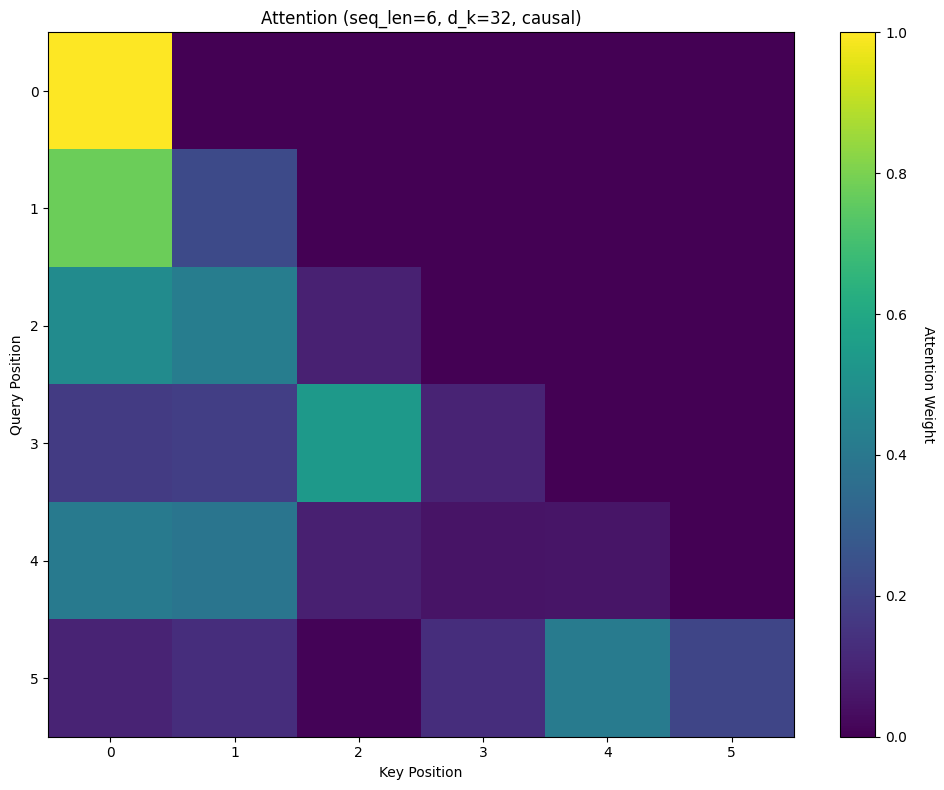

Shapes: Q=torch.Size([1, 6, 32]), output=torch.Size([1, 6, 32]), attention=torch.Size([1, 6, 6])

Things to try:
  1. Set all K to be identical → uniform attention
  2. Make one Q-K pair very similar → peaked attention
  3. Increase d_k → see effect on score magnitudes
  4. Toggle use_mask → see causal vs uncausal
  5. Set V to one-hot vectors → see which values are selected


In [16]:
# Playground - Modify these parameters and see what happens!

# Parameters to experiment with
batch_size = 1
seq_len = 6      # Try: 4, 8, 16
d_k = 32         # Try: 8, 16, 64, 128
use_mask = True  # Try: True, False

# Create inputs
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

# Apply attention
if use_mask:
    mask = create_causal_mask(seq_len).unsqueeze(0)
    output, attention = scaled_dot_product_attention(Q, K, V, mask=mask)
    title = f"Attention (seq_len={seq_len}, d_k={d_k}, causal)"
else:
    output, attention = scaled_dot_product_attention(Q, K, V)
    title = f"Attention (seq_len={seq_len}, d_k={d_k}, uncausal)"

# Visualize
plot_attention_pattern(attention[0], title=title)
plt.show()

print(f"Shapes: Q={Q.shape}, output={output.shape}, attention={attention.shape}")

# Experiments to try:
print("\nThings to try:")
print("  1. Set all K to be identical → uniform attention")
print("  2. Make one Q-K pair very similar → peaked attention")
print("  3. Increase d_k → see effect on score magnitudes")
print("  4. Toggle use_mask → see causal vs uncausal")
print("  5. Set V to one-hot vectors → see which values are selected")

## Summary

You've now explored:

✓ **Components**: Query, Key, Value and their roles  
✓ **Computation**: Q@K^T, scaling, softmax, weighted sum  
✓ **Scaling**: Why √d_k prevents softmax saturation  
✓ **Masking**: Causal masks for autoregressive generation  
✓ **Complexity**: O(n²) time and space  
✓ **Visualization**: Attention patterns as heatmaps  
✓ **Experimentation**: Hands-on exploration  

## Next Steps

1. ✓ Complete the exercises in `exercises/exercises.py`
2. ✓ Review `exercises/solutions.py` for detailed implementations
3. ✓ Read the test suite in `tests/test_attention.py`
4. ✓ Move on to Module 02: Multi-Head Attention!

**Congratulations! You now understand the attention mechanism!** 🎉